In [ ]:
# Cell 1: Setup and Google Drive Access
import pandas as pd
import numpy as np
import glob
import requests
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully.")

Mounted at /content/drive
✅ Google Drive mounted successfully.


In [ ]:
file_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/gongguan_case_study_data.parquet.gz"

# Read the data into a pandas DataFrame
df_features = pd.read_parquet(file_path)

In [ ]:
df_features

,sno,time,act,total,available_rent_bikes,available_return_bikes,hour,is_weekday,lat,lng,sareaen,snaen,occupancy_ratio
119520,500101003,2024-05-04 00:00:00,1,16,12,4,0,False,25.02429,121.54124,Daan Dist.,NTUE Experiment Elementary School (East),0.750000
119521,500101003,2024-05-04 00:10:00,1,16,12,4,0,False,25.02429,121.54124,Daan Dist.,NTUE Experiment Elementary School (East),0.750000
119522,500101003,2024-05-04 00:20:00,1,16,15,1,0,False,25.02429,121.54124,Daan Dist.,NTUE Experiment Elementary School (East),0.937500
119523,500101003,2024-05-04 00:30:00,1,16,15,1,0,False,25.02429,121.54124,Daan Dist.,NTUE Experiment Elementary School (East),0.937500
119524,500101003,2024-05-04 00:40:00,1,16,16,0,0,False,25.02429,121.54124,Daan Dist.,NTUE Experiment Elementary School (East),1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74460955,500119091,2025-06-22 23:10:00,1,18,17,1,23,False,25.01816,121.54469,NTU Dist,NTU Ming - Da Hall (Staff Dormitory),0.944444
74460956,500119091,2025-06-22 23:20:00,1,18,17,1,23,False,25.01816,121.54469,NTU Dist,NTU Ming - Da Hall (Staff Dormitory),0.944444
74460957,500119091,2025-06-22 23:30:00,1,18,17,1,23,False,25.01816,121.54469,NTU Dist,NTU Ming - Da Hall (Staff Dormitory),0.944444
74460958,500119091,2025-06-22 23:40:00,1,18,17,1,23,False,25.01816,121.54469,NTU Dist,NTU Ming - Da Hall (Staff Dormitory),0.944444


In [ ]:
# Define the path to your consolidated_resampled_filtered Parquet file
file_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data_with_ratio.parquet.gz"

# Read the data into a pandas DataFrame
df_features = pd.read_parquet(file_path)

In [ ]:
import pandas as pd

print("--- Engineering Feature for Major Storm/Typhoon Days ---")

# --- Step 1: Define the anomaly dates based on visual evidence ---
# These are the dates where the plots showed a clear, anomalous drop in occupancy.
typhoon_shanshan_dates = pd.to_datetime([
    '2024-08-28', '2024-08-29', '2024-08-30'
]).date

typhoon_krathon_dates = pd.to_datetime([
    '2024-09-30', # Day of approach
    '2024-10-01', # Major impact
    '2024-10-02'  # Major impact
]).date

# For November, we'll assume the dates from our previous analysis.
# Adjust these if your visual inspection of the November plot suggests different dates.
november_monsoon_dates = pd.to_datetime([
    '2024-11-12', '2024-11-13', '2024-11-14'
]).date

# Combine all storm dates into a single set for efficient lookup
all_storm_dates = set(typhoon_shanshan_dates) | set(typhoon_krathon_dates) | set(november_monsoon_dates)


# --- Step 2: Create the binary feature ---
# Ensure 'time' is a datetime object
if 'time' not in df_features.columns:
    df_features.reset_index(inplace=True)
df_features['time'] = pd.to_datetime(df_features['time'])

# The .isin() method is highly efficient for this check
is_major_storm_day_mask = df_features['time'].dt.date.isin(all_storm_dates)

# Convert the boolean mask (True/False) to an integer (1/0)
df_features['is_major_storm_day'] = is_major_storm_day_mask.astype(int)


# --- Step 3: Verify the result ---
print("✅ 'is_major_storm_day' feature created successfully.")
print(f"Total data points flagged as storm days: {df_features['is_major_storm_day'].sum()}")
print("\nExample of flagged data from Typhoon Krathon:")
print(df_features[df_features['time'].dt.date.isin(typhoon_krathon_dates)].head())

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Part 1: Creating Behavioral Profiles for Each Station ---")

# Ensure 'hour' column exists
if 'hour' not in df_features.columns:
    df_features['hour'] = df_features['time'].dt.hour

# Calculate the average occupancy for each station at each hour of the day
station_hourly_avg = df_features[df_features['act'] == 1].groupby(['sno', 'hour'])['occupancy_ratio'].mean()

# Pivot the data to create the station profiles (rows=stations, columns=hours)
station_profiles = station_hourly_avg.unstack(level='hour')

# Fill any NaN values that might result from a station having no data for a specific hour
station_profiles.fillna(0, inplace=True)

print("✅ Station profiles created successfully.")
print("Shape of profiles DataFrame:", station_profiles.shape)
print(station_profiles.head())

In [ ]:
print("\n--- Part 2: Applying K-Means Clustering ---")

# Choose the number of clusters
N_CLUSTERS = 5

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(station_profiles)

# Add the cluster labels to our profiles DataFrame
station_profiles['station_cluster'] = clusters

print(f"✅ Stations have been grouped into {N_CLUSTERS} clusters.")
print(station_profiles[['station_cluster']].head())

In [ ]:
print("\n--- Part 3: Visualizing and Interpreting the Clusters ---")

plt.figure(figsize=(15, 8))

# Plot the average profile for each cluster
for i in range(N_CLUSTERS):
    cluster_profile = station_profiles[station_profiles['station_cluster'] == i].drop('station_cluster', axis=1)
    plt.plot(cluster_profile.mean(axis=0), label=f'Cluster {i} ({len(cluster_profile)} stations)')

plt.title('Average Daily Occupancy Profiles by Station Cluster', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Average Occupancy Ratio')
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
print("\n--- Part 4: Merging Cluster Feature into Main DataFrame ---")

# Get just the sno and its assigned cluster
cluster_mapping = station_profiles[['station_cluster']].reset_index()

# Merge this mapping back into the main DataFrame
df_features = pd.merge(df_features, cluster_mapping, on='sno', how='left')

print("✅ 'station_cluster' feature has been added to the main DataFrame.")
print(df_features[['time', 'sno', 'occupancy_ratio', 'station_cluster']].head())

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Make sure your district column has a consistent name ---
# ⚠️ IMPORTANT: Replace 'sareaen' with the actual name of your district column if different.
DISTRICT_COL = 'sareaen'

print(f"--- Analyzing the distribution of station clusters across districts ---")

# We only need one entry per station for this analysis
station_info = df_features[['sno', 'station_cluster', DISTRICT_COL]].drop_duplicates()

# Create a crosstabulation to see the count of each cluster in each district
crosstab_df = pd.crosstab(station_info[DISTRICT_COL], station_info['station_cluster'])

# Normalize the crosstab by row to see the *percentage* of each cluster within a district
crosstab_normalized = crosstab_df.div(crosstab_df.sum(axis=1), axis=0)

# --- Visualize the relationship with a heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(
    crosstab_normalized,
    annot=True,
    fmt=".2f", # Format to 2 decimal places
    cmap="YlGnBu",
    linewidths=.5
)
plt.title('Proportion of Station Clusters within Each District', fontsize=16)
plt.xlabel('Station Cluster')
plt.ylabel('District')
plt.show()

In [ ]:
import pandas as pd

print("--- Engineering a Feature for 2024 Typhoon & Major Storm Events ---")

# Ensure 'time' is a datetime object
df_features['time'] = pd.to_datetime(df_features['time'])

# Define the date ranges for the major 2024 events impacting Taipei
# These should cover the days with official warnings or major disruptions
typhoon_shanshan_dates = pd.to_datetime(['2024-08-28', '2024-08-29', '2024-08-30'])
typhoon_krathon_dates = pd.to_datetime(['2024-09-30', '2024-10-01', '2024-10-02'])

# ⚠️ For the November dip, identify the exact dates from your plot, as it's a monsoon event
# Let's assume the dip was around the 12th-14th based on a typical pattern
november_monsoon_dates = pd.to_datetime(['2024-11-12', '2024-11-13', '2024-11-14'])

# Create a boolean mask for any day that falls within these periods
is_major_storm_day = (df_features['time'].dt.date.isin(typhoon_shanshan_dates.date)) | \
                     (df_features['time'].dt.date.isin(typhoon_krathon_dates.date)) | \
                     (df_features['time'].dt.date.isin(november_monsoon_dates.date))

# Create the binary feature
df_features['is_major_storm_day'] = is_major_storm_day.astype(int)

print("✅ 'is_major_storm_day' feature created.")
print("Number of data points flagged as major storm days:", df_features['is_major_storm_day'].sum())

In [ ]:
print("Creating lag features for 'occupancy_ratio'...")

# Group by station to create lags correctly for each station individually
grouped_by_station = df_features.groupby('sno')

# Create a 10-minute, 30-minute, and 60-minute lag
df_features['occupancy_ratio_lag_10m'] = grouped_by_station['occupancy_ratio'].shift(1) # 1 * 10 min
df_features['occupancy_ratio_lag_30m'] = grouped_by_station['occupancy_ratio'].shift(3) # 3 * 10 min
df_features['occupancy_ratio_lag_1hr'] = grouped_by_station['occupancy_ratio'].shift(6) # 6 * 10 min

# Fill any initial NaN values created by the shift
df_features.fillna(method='bfill', inplace=True)

print("✅ Lag features created.")
print(df_features[['time', 'sno', 'occupancy_ratio', 'occupancy_ratio_lag_10m']].head())

# One hot encoding

In [ ]:
print("--- Engineering a new 'cluster_district' interaction feature ---")

# Concatenate the cluster and district names to create a new feature
# We convert the cluster number to a string to do this
df_features['cluster_district'] = 'cluster_' + df_features['station_cluster'].astype(str) + '_' + df_features[DISTRICT_COL]

print("✅ New interaction feature created.")
print("Example of the new feature:")
print(df_features[['sno', 'station_cluster', DISTRICT_COL, 'cluster_district']].sample(5))


# --- Final Step: One-Hot Encode the New Feature ---
print("\nOne-hot encoding the new 'cluster_district' feature...")

# One-hot encode the new combined feature for the model
df_features_encoded = pd.get_dummies(df_features, columns=['cluster_district'], prefix='loc')

# It's good practice to also drop the original columns that are now redundant
df_features_encoded.drop(columns=['station_cluster', DISTRICT_COL], inplace=True)

print("✅ Interaction feature has been one-hot encoded.")
print("A sample of the final columns:")
print(df_features_encoded.head())

# Update your main dataframe
df_features = df_features_encoded

# Weather

Loading prepared Ubike and final weather data...
✅ Datasets loaded successfully.

--- Step 2: Merging Ubike and weather data ---
✅ Merge complete.

--- Step 3: Aggregating data to hourly level for numerical analysis ---
✅ Data aggregated.

--- Analysis A: Generating Correlation Heatmap ---


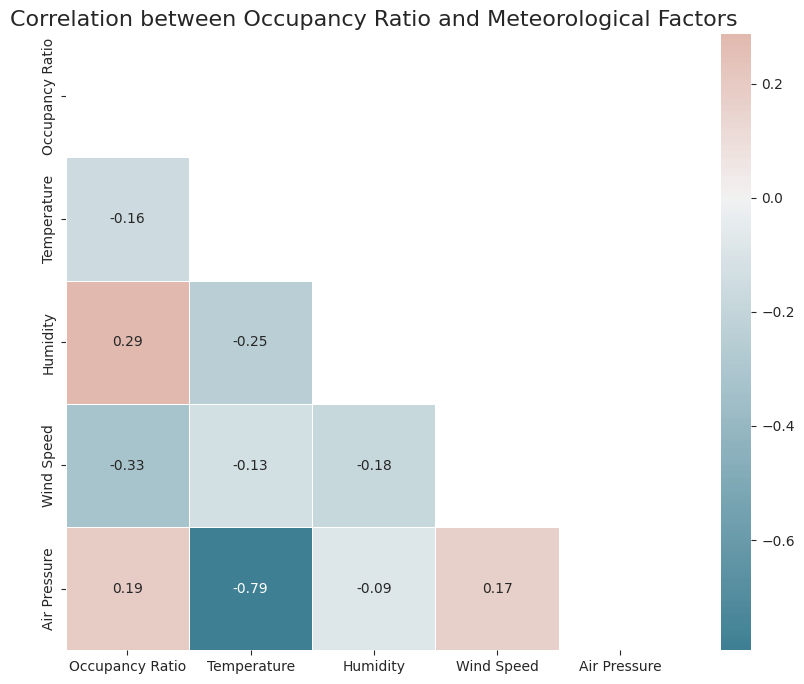


--- Analysis B: Visualizing Impact of Weather Conditions ---


/tmp/ipython-input-688664113.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Condition', x='occupancy_ratio', data=df_analysis, order=order, palette='coolwarm_r')


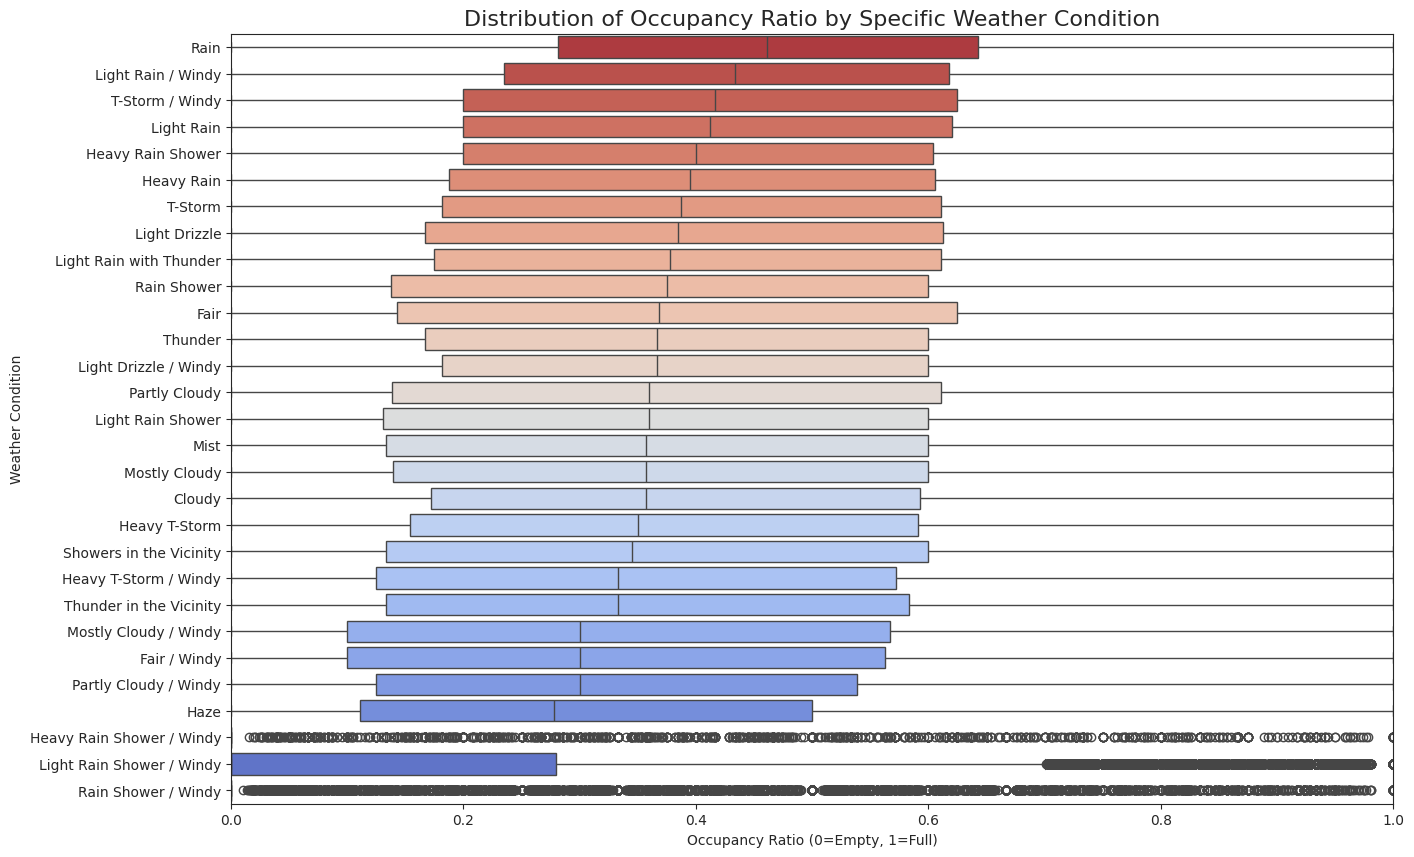


--- Analysis C: Generating Sanity Check Box Plots ---


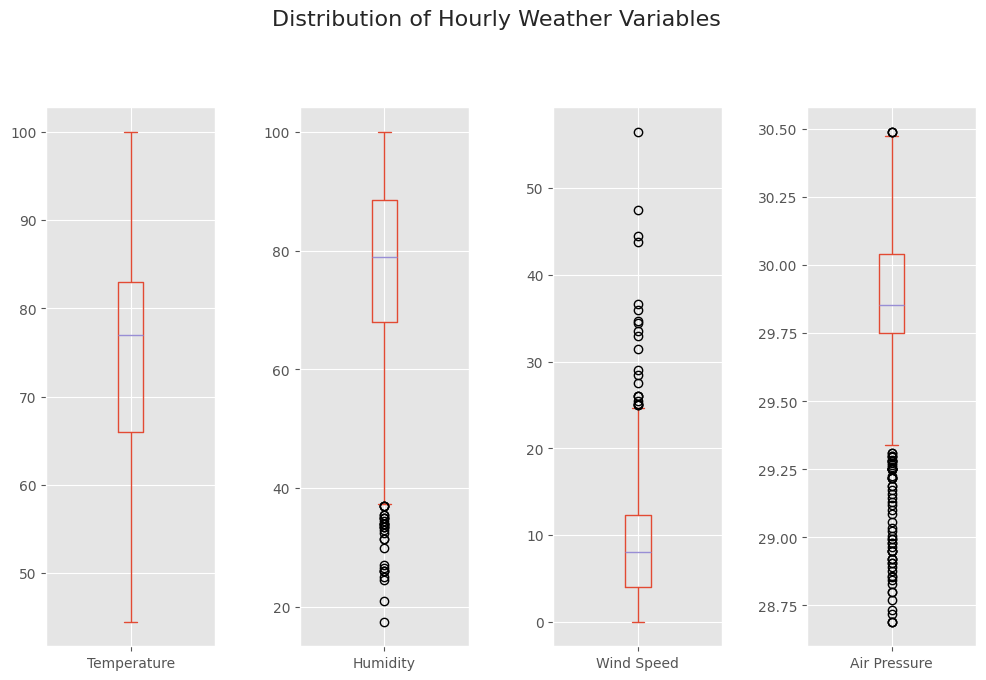

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# --- 1. Load and Merge Datasets ---
print("Loading prepared Ubike and final weather data...")
# Load Ubike data (loading only essential columns for this task)
# --- THE FIX IS HERE: Add 'sno' to the list of columns to load ---
ubike_cols = ['time', 'sno', 'act', 'occupancy_ratio']
ubike_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data_with_ratio.parquet.gz"
df_features = pd.read_parquet(ubike_path, columns=ubike_cols)

# Load the final, cleaned 10-minute weather data
weather_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/weather_final_10min.parquet.gz"
df_weather = pd.read_parquet(weather_path)
print("✅ Datasets loaded successfully.")


# --- 2. Merge Datasets ---
print("\n--- Step 2: Merging Ubike and weather data ---")
# Prepare timestamp columns for merging
df_features['time'] = pd.to_datetime(df_features['time'])
df_weather['time'] = pd.to_datetime(df_weather['Timestamp'])

# Merge using a left join to keep all bike data
df_merged = pd.merge(df_features, df_weather.drop(columns='Timestamp'), on='time', how='left')

# Forward-fill to handle any weather data gaps and propagate hourly readings
df_merged.sort_values(by=['sno', 'time'], inplace=True)
df_merged.ffill(inplace=True)
print("✅ Merge complete.")


# --- 3. Data Aggregation for Numerical Analysis ---
# For a stable correlation signal, it's best to aggregate data hourly.
print("\n--- Step 3: Aggregating data to hourly level for numerical analysis ---")
df_hourly_agg = df_merged[df_merged['act'] == 1].set_index('time').resample('h').mean(numeric_only=True)
df_hourly_agg.rename(columns={
    'occupancy_ratio': 'Occupancy Ratio',
    'Speed': 'Wind Speed',
    'Pressure': 'Air Pressure'
}, inplace=True)
print("✅ Data aggregated.")





--- Step 1: Loading prepared Ubike and final weather data ---
Selectively loading 5 columns from the Ubike data...
✅ Datasets loaded successfully.

--- Step 2: Merging Ubike and weather data ---
✅ Merge complete.

--- Step 3: Analyzing Correlation by District ---

--- Step 4: Visualizing the correlation results ---


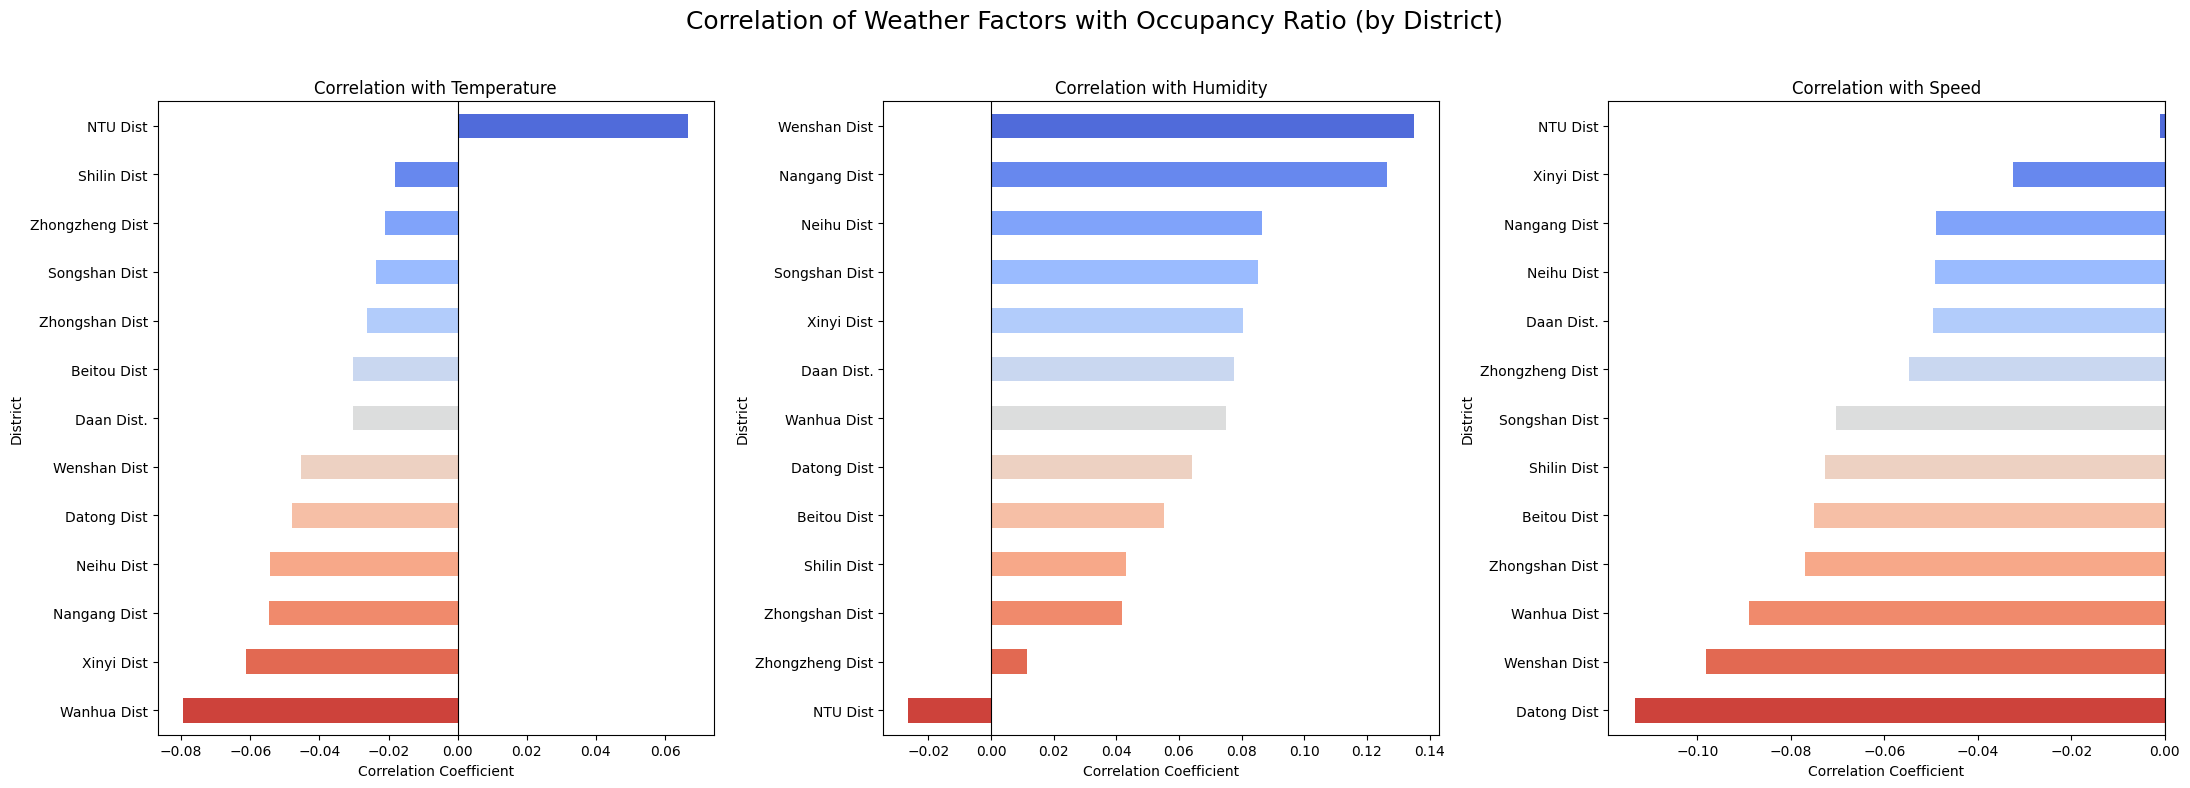

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Datasets (Memory-Safe) ---
print("--- Step 1: Loading prepared Ubike and final weather data ---")

# ⚠️ IMPORTANT: Replace 'sareaen' with the actual name of your district column if different.
DISTRICT_COL = 'sareaen'

# Define only the columns we need for this specific analysis
ubike_cols_to_load = ['time', 'sno', 'act', 'occupancy_ratio', DISTRICT_COL]
ubike_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data_with_ratio.parquet.gz" # Assumed path with ratio and district

print(f"Selectively loading {len(ubike_cols_to_load)} columns from the Ubike data...")
df_features = pd.read_parquet(ubike_path, columns=ubike_cols_to_load)

# Load the final, cleaned 10-minute weather data
weather_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/weather_final_10min.parquet.gz"
df_weather = pd.read_parquet(weather_path)
print("✅ Datasets loaded successfully.")


# --- 2. Merge Datasets ---
print("\n--- Step 2: Merging Ubike and weather data ---")
# Prepare timestamp columns for merging
df_features['time'] = pd.to_datetime(df_features['time'])
df_weather['time'] = pd.to_datetime(df_weather['Timestamp'])

# Merge using a left join to keep all bike data
df_merged = pd.merge(df_features, df_weather.drop(columns='Timestamp'), on='time', how='left')

# Forward-fill to handle any weather data gaps
df_merged.sort_values(by=['sno', 'time'], inplace=True)
df_merged.ffill(inplace=True)
print("✅ Merge complete.")


# --- 3. Analyze Correlation by District ---
print("\n--- Step 3: Analyzing Correlation by District ---")

# Group by district and calculate the correlation matrix for key numerical columns
correlation_by_district = df_merged[df_merged['act'] == 1].groupby(DISTRICT_COL)[['occupancy_ratio', 'Temperature', 'Humidity', 'Speed']].corr(numeric_only=True)

# Extract only the correlations with 'occupancy_ratio' for easier plotting
occupancy_corr_district = correlation_by_district.unstack().loc[:, 'occupancy_ratio']


# --- 4. Visualize the Results ---
print("\n--- Step 4: Visualizing the correlation results ---")
weather_factors = ['Temperature', 'Humidity', 'Speed']
fig, axes = plt.subplots(1, len(weather_factors), figsize=(22, 8), sharey=False)
fig.suptitle('Correlation of Weather Factors with Occupancy Ratio (by District)', fontsize=18)

for i, factor in enumerate(weather_factors):
    # Sort for better visualization
    sorted_corr = occupancy_corr_district[factor].sort_values()

    # Create horizontal bar plot
    sorted_corr.plot(kind='barh', ax=axes[i], color=sns.color_palette("coolwarm_r", n_colors=len(sorted_corr)))

    axes[i].set_title(f'Correlation with {factor}')
    axes[i].axvline(0, color='black', linewidth=0.8) # Add a line at zero for reference
    axes[i].set_xlabel('Correlation Coefficient')
    axes[i].set_ylabel('District')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#Special Days

In [ ]:
import pandas as pd
import numpy as np # Import numpy for the vectorized solution

print("--- Engineering Features for Holidays and Special Days (Memory-Safe Version) ---")

# --- 1. Define the special dates for 2024 & 2025 based on official sources ---
holiday_dates = {
    # --- 2024 Holidays ---
    '2024-05-01': 'Labor Day',
    '2024-06-10': 'Dragon Boat Festival',
    '2024-09-17': 'Mid-Autumn Festival',
    '2024-10-10': 'National Day',

    # --- 2025 Holidays (Jan-June) ---
    '2025-01-01': "New Year's Day",
    '2025-01-27': 'LNY Bridge Holiday',
    '2025-01-28': 'Lunar New Year',
    '2025-01-29': 'Lunar New Year',
    '2025-01-30': 'Lunar New Year',
    '2025-01-31': 'Lunar New Year',
    '2025-02-28': '228 Peace Memorial Day',
    '2025-04-03': 'Childrens/Tomb Sweeping Bridge',
    '2025-04-04': 'Childrens/Tomb Sweeping Day',
    '2025-05-01': 'Labor Day',
    '2025-05-29': 'Dragon Boat Festival',
    '2025-05-30': 'Dragon Boat Bridge Holiday'
}

makeup_workdays = {
    # --- 2025 Make-up Workdays ---
    '2025-02-08': 'Make-up for LNY',
    '2025-03-29': 'Make-up for Tomb Sweeping',
    '2025-06-07': 'Make-up for Dragon Boat'
}

# Convert the keys of the dictionaries to datetime.date objects for efficient lookup
holiday_dates_set = set(pd.to_datetime(list(holiday_dates.keys())).date)
makeup_workdays_set = set(pd.to_datetime(list(makeup_workdays.keys())).date)


# --- 2. Create the features in your DataFrame ---
# Assuming df_features is your main DataFrame
df_features['time'] = pd.to_datetime(df_features['time'])
df_features['date'] = df_features['time'].dt.date
df_features['is_holiday'] = df_features['date'].isin(holiday_dates_set).astype(int)
df_features['is_makeup_day'] = df_features['date'].isin(makeup_workdays_set).astype(int)
df_features['day_of_week'] = df_features['time'].dt.dayofweek


# --- 3. Create 'day_type' feature using a Memory-Efficient Vectorized Method ---
print("\nCreating a combined 'day_type' feature using a vectorized method...")

# Define the conditions in order of priority (make-up day is highest)
conditions = [
    df_features['is_makeup_day'] == 1,
    df_features['is_holiday'] == 1,
    df_features['day_of_week'] >= 5 # Saturday or Sunday
]

# Define the corresponding choices for each condition
choices = [
    'Weekday',
    'Holiday',
    'Weekend'
]

# np.select will pick the choice based on the first condition that is True.
# If no conditions are True, it will use the default value.
df_features['day_type'] = np.select(conditions, choices, default='Weekday')


# --- 4. Verify and Clean Up ---
print("\n✅ Holiday and day_type features created successfully.")
print("\nVerification for 2025 Lunar New Year (should be 'Holiday'):")
print(df_features[df_features['date'] == pd.to_datetime('2025-01-29').date()][['time', 'day_type']].head())

print("\nVerification for 2025 LNY Make-up Day (should be 'Weekday'):")
print(df_features[df_features['date'] == pd.to_datetime('2025-02-08').date()][['time', 'day_type']].head())

print("\nValue counts for the new 'day_type' feature:")
print(df_features['day_type'].value_counts())

# Drop the helper columns
df_features.drop(columns=['date', 'day_of_week'], inplace=True)

--- Engineering Features for Holidays and Special Days (Memory-Safe Version) ---

Creating a combined 'day_type' feature using a vectorized method...

✅ Holiday and day_type features created successfully.

Verification for 2025 Lunar New Year (should be 'Holiday'):
                     time day_type
38880 2025-01-29 00:00:00  Holiday
38881 2025-01-29 00:10:00  Holiday
38882 2025-01-29 00:20:00  Holiday
38883 2025-01-29 00:30:00  Holiday
38884 2025-01-29 00:40:00  Holiday

Verification for 2025 LNY Make-up Day (should be 'Weekday'):
                     time day_type
40320 2025-02-08 00:00:00  Weekday
40321 2025-02-08 00:10:00  Weekday
40322 2025-02-08 00:20:00  Weekday
40323 2025-02-08 00:30:00  Weekday
40324 2025-02-08 00:40:00  Weekday

Value counts for the new 'day_type' feature:
day_type
Weekday    50776992
Weekend    20992608
Holiday     2691360
Name: count, dtype: int64


#All

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

print("--- Feature Engineering for Deep Learning Models (TFT, PatchTST) ---")

# --- 1. Load Necessary Data ---
print("Step 1: Loading base Ubike and weather data...")
ubike_cols_to_load = ['time', 'sno', 'act', 'occupancy_ratio', 'sareaen']
ubike_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data_with_ratio.parquet.gz"
df_features = pd.read_parquet(ubike_path, columns=ubike_cols_to_load)
df_features['time'] = pd.to_datetime(df_features['time'])

weather_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/weather_final_10min.parquet.gz"
df_weather = pd.read_parquet(weather_path)
df_weather['time'] = pd.to_datetime(df_weather['Timestamp'])


# --- 2. Merge Weather Data ---
print("\nStep 2: Merging weather data...")
df_merged = pd.merge(df_features, df_weather.drop(columns='Timestamp'), on='time', how='left')
df_merged.sort_values(by=['sno', 'time'], inplace=True)
df_merged.ffill(inplace=True)


# --- 3. Engineer Time-Based and Special Day Features ---
print("\nStep 3: Engineering time-based and holiday features...")
# (Using the corrected, extended holiday list from May 2024 - June 2025)
holiday_dates = {
    '2024-05-01': 'Labor Day','2024-06-10': 'Dragon Boat Festival','2024-09-17': 'Mid-Autumn Festival','2024-10-10': 'National Day',
    '2025-01-01': "New Year's Day",'2025-01-27': 'LNY Bridge Holiday','2025-01-28': 'Lunar New Year','2025-01-29': 'Lunar New Year',
    '2025-01-30': 'Lunar New Year','2025-01-31': 'Lunar New Year','2025-02-28': '228 Peace Memorial Day',
    '2025-04-03': 'Childrens/Tomb Sweeping Bridge','2025-04-04': 'Childrens/Tomb Sweeping Day','2025-05-01': 'Labor Day',
    '2025-05-29': 'Dragon Boat Festival','2025-05-30': 'Dragon Boat Bridge Holiday'
}
makeup_workdays = {
    '2025-02-08': 'Make-up for LNY','2025-03-29': 'Make-up for Tomb Sweeping','2025-06-07': 'Make-up for Dragon Boat'
}
holiday_dates_set = set(pd.to_datetime(list(holiday_dates.keys())).date)
makeup_workdays_set = set(pd.to_datetime(list(makeup_workdays.keys())).date)

df_merged['date'] = df_merged['time'].dt.date
df_merged['is_holiday'] = df_merged['date'].isin(holiday_dates_set)
df_merged['is_makeup_day'] = df_merged['date'].isin(makeup_workdays_set)
df_merged['day_of_week'] = df_merged['time'].dt.dayofweek
df_merged['hour'] = df_merged['time'].dt.hour

conditions = [
    df_merged['is_makeup_day'] == True,
    df_merged['is_holiday'] == True,
    df_merged['day_of_week'] >= 5
]
choices = ['Weekday', 'Holiday', 'Weekend']
df_merged['day_type'] = np.select(conditions, choices, default='Weekday')


# --- 4. Engineer Behavioral Clustering Feature ---
print("\nStep 4: Engineering station cluster feature...")
station_hourly_avg = df_merged[df_merged['act'] == 1].groupby(['sno', 'hour'])['occupancy_ratio'].mean()
station_profiles = station_hourly_avg.unstack(level='hour').fillna(0)
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(station_profiles)
station_profiles['station_cluster'] = clusters
cluster_mapping = station_profiles[['station_cluster']].reset_index()
df_merged = pd.merge(df_merged, cluster_mapping, on='sno', how='left')


# --- 5. Final Preparation for Deep Learning ---
print("\nStep 5: Final preparation for DL models (encoding and normalization)...")
# Drop unnecessary columns
df_dl = df_merged.drop(columns=['date', 'is_holiday', 'is_makeup_day', 'sareaen', 'Wind', 'Condition'])

# **One-Hot Encode** the most important categorical features
# We are selective to manage memory.
print("One-hot encoding 'day_type' and 'station_cluster'...")
df_dl = pd.get_dummies(df_dl, columns=['day_type', 'station_cluster'], prefix=['day_is', 'cluster_is'])

# **Normalize** numerical features to a 0-1 range
print("Normalizing numerical features...")
numerical_cols = ['Temperature', 'Dew Point', 'Humidity', 'Speed', 'Pressure']
scaler = MinMaxScaler()
df_dl[numerical_cols] = scaler.fit_transform(df_dl[numerical_cols])


# --- 6. Save the final dataset ---
print("\n--- Final DataFrame Info (Memory Usage) ---")
df_dl.info(memory_usage='deep')
final_output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/model_ready_dl_features.parquet.gz"
df_dl.to_parquet(final_output_path, compression='gzip')
print(f"✅ Final dataset for DL models saved to {final_output_path}")


--- Feature Engineering for Deep Learning Models (TFT, PatchTST) ---
Step 1: Loading base Ubike and weather data...

Step 2: Merging weather data...

Step 3: Engineering time-based and holiday features...

Step 4: Engineering station cluster feature...

Step 5: Final preparation for DL models (encoding and normalization)...
One-hot encoding 'day_type' and 'station_cluster'...
Normalizing numerical features...

--- Final DataFrame Info (Memory Usage) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74460960 entries, 0 to 74460959
Data columns (total 19 columns):
 #   Column           Dtype         
---  ------           -----         
 0   time             datetime64[ns]
 1   sno              int64         
 2   act              int64         
 3   occupancy_ratio  float64       
 4   Temperature      float64       
 5   Dew Point        float64       
 6   Humidity         float64       
 7   Speed            float64       
 8   Pressure         float64       
 9   day_of_week    

In [ ]:
import pandas as pd

print("--- Engineering Historical Activity and Lag Features ---")

# --- 1. Load the dataset with all other features ---
# This should be the file from after you've added holidays, clusters, etc.
# For now, we'll start from the file with the occupancy ratio.
ubike_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/ubike_final_data_with_ratio.parquet.gz"
# We need 'available_rent_bikes' to calculate inflow/outflow
cols_to_load = ['time', 'sno', 'occupancy_ratio', 'available_rent_bikes']
df = pd.read_parquet(ubike_path, columns=cols_to_load)
df['time'] = pd.to_datetime(df['time'])
df.sort_values(['sno', 'time'], inplace=True)


# --- 2. Create Lag Features for Occupancy Ratio ---
print("\nStep 2: Creating lag features for 'occupancy_ratio'...")
# We group by station to ensure lags are calculated within each station's timeline
grouped = df.groupby('sno')

# Define the lag periods (1 = 10 mins ago, 3 = 30 mins ago, 6 = 1 hour ago)
lags = [1, 2, 3, 6]
for lag in lags:
    df[f'occupancy_ratio_lag_{lag*10}m'] = grouped['occupancy_ratio'].shift(lag)

print("✅ Occupancy ratio lag features created.")


# --- 3. Create Inflow/Outflow Features (Demand Activity) ---
print("\nStep 3: Calculating inflow/outflow activity...")
# Calculate the change in available bikes from the previous time step
df['bike_change'] = grouped['available_rent_bikes'].diff()

# Separate this into inflow (positive change) and outflow (negative change)
df['inflow'] = df['bike_change'].apply(lambda x: x if x > 0 else 0)
df['outflow'] = df['bike_change'].apply(lambda x: -x if x < 0 else 0) # Make outflow positive

print("✅ Inflow and outflow calculated.")


# --- 4. Create Lag Features for Inflow/Outflow ---
print("\nStep 4: Creating lag features for activity...")
# We need to re-group because we added new columns
grouped = df.groupby('sno')
activity_lags = [1, 2, 3, 6]
for lag in activity_lags:
    df[f'inflow_lag_{lag*10}m'] = grouped['inflow'].shift(lag)
    df[f'outflow_lag_{lag*10}m'] = grouped['outflow'].shift(lag)

print("✅ Activity lag features created.")


# --- 5. Clean Up and Save ---
# The shift operations create NaNs at the beginning of each station's history.
# We will fill these with 0, as it's a reasonable assumption for the start of the data.
df.fillna(0, inplace=True)

# Drop intermediate columns
df.drop(columns=['available_rent_bikes', 'bike_change'], inplace=True)

print("\n--- Final DataFrame Head ---")
print(df.head())

# Save the final dataset
# This file should now be merged with your other features (weather, POI, etc.)
# to create the final model-ready dataset.
output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/youbike_poi_output.parquet.gz"
df.to_parquet(output_path, compression='gzip')
print(f"\n✅ Activity features saved to {output_path}")


#POI

In [ ]:
import pandas as pd

print("--- Engineering Features from Point of Interest (POI) Data ---")
print("This version uses a category map tailored to the observed POI types.")

# --- 1. Load the Raw POI Data ---
poi_file_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/youbike_poi_output.csv"
df_poi_raw = pd.read_csv(poi_file_path)
print(f"Loaded {len(df_poi_raw)} raw POI records.")


# --- 2. Harmonize Station Names (CRUCIAL FIX) ---
print("\nStep 2: Removing 'YouBike2.0_' prefix to match main dataset...")
df_poi_raw['station_name'] = df_poi_raw['station_name'].str.replace('YouBike2.0_', '', regex=False)
print("✅ Station names harmonized.")


# --- 3. Feature Engineering: Grouped POI Categories (Tailored Version) ---
print("\nStep 3: Mapping raw POI types to engineered categories...")

# This map is tailored to the top types found in the poi_type_analysis script.
# It is more concise but less robust to new, unseen POI types.
category_map = {
    # Food & Drink (most common group)
    'restaurant': 'poi_food_drink', 'cafe': 'poi_food_drink', 'meal_takeaway': 'poi_food_drink',
    'bar': 'poi_food_drink', 'bakery': 'poi_food_drink', 'meal_delivery': 'poi_food_drink',
    'liquor_store': 'poi_food_drink',
    # Retail/Shopping
    'store': 'poi_retail', 'department_store': 'poi_retail', 'book_store': 'poi_retail',
    'furniture_store': 'poi_retail',
    # Groceries
    'grocery_or_supermarket': 'poi_supermarket', 'supermarket': 'poi_supermarket',
    'convenience_store': 'poi_supermarket',
    # Services & Leisure
    'lodging': 'poi_lodging', 'night_club': 'poi_lodging',
    'health': 'poi_health_medical',
    'hair_care': 'poi_misc_service',
    'gym': 'poi_gym',
    'park': 'poi_park'
    # NOTE: High-impact types like 'subway_station' are kept even if not in top 20
    'subway_station': 'poi_subway_station', 'bus_station': 'poi_bus_station'
}

# Clean the 'types' column, extract the primary type, and map it
df_poi_raw['primary_type'] = df_poi_raw['types'].apply(lambda x: str(x).split(';')[0].strip())
df_poi_raw['poi_category'] = df_poi_raw['primary_type'].map(category_map)
df_poi_raw['poi_category'].fillna('poi_other', inplace=True)

# One-hot encode these new categories
df_poi_categorized = pd.get_dummies(df_poi_raw, columns=['poi_category'], prefix='')
print("✅ POIs categorized and one-hot encoded.")


# --- 4. Aggregate Features for Each Station ---
print("\nStep 4: Aggregating features for each station...")
aggregations = {
    'rating': 'mean',
    'user_ratings_total': 'sum'
}
for col in df_poi_categorized.columns:
    if col.startswith('poi_'):
        aggregations[col] = 'sum'

# Perform the aggregation
df_station_poi_features = df_poi_categorized.groupby('station_name').agg(aggregations).reset_index()

df_station_poi_features.rename(columns={
    'rating': 'poi_avg_rating',
    'user_ratings_total': 'poi_total_user_ratings'
}, inplace=True)
print("✅ POI features aggregated successfully.")


# --- 5. Save the Final POI Feature Set ---
poi_output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/station_poi_features_final.parquet"
df_station_poi_features.to_parquet(poi_output_path)
print(f"\n✅ Final POI features saved to {poi_output_path}")



#Seperate

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

print("--- Master Feature Engineering Pipeline for Gongguan Case Study ---")

# --- 1. Load All Necessary Raw Datasets ---
print("\nStep 1: Loading all source datasets...")
gongguan_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/gongguan_case_study_data.parquet.gz"
df = pd.read_parquet(gongguan_path)
df['time'] = pd.to_datetime(df['time'])

weather_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/weather_final_10min.parquet.gz"
df_weather = pd.read_parquet(weather_path)
df_weather['time'] = pd.to_datetime(df_weather['Timestamp'])

poi_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/youbike_poi_output.csv"
df_poi = pd.read_csv(poi_path)
print("✅ All source data loaded.")


# --- 2. Merge External Data (Weather and POI) ---
print("\nStep 2: Merging external Weather and POI data...")
df = pd.merge(df, df_weather.drop(columns='Timestamp'), on='time', how='left')
df = pd.merge(df, df_poi, left_on='snaen', right_on='station_name', how='left')
df.drop(columns='station_name', inplace=True)
df.sort_values(['sno', 'time'], inplace=True)
df.ffill(inplace=True)
print("✅ External data merged successfully.")


# --- 3. Engineer Time-Based & Event Features ---
print("\nStep 3: Engineering time, holiday, storm, and cyclical features...")
# Simple time features (raw versions)
df['hour_raw'] = df['time'].dt.hour
df['day_of_week_raw'] = df['time'].dt.dayofweek
df['month_raw'] = df['time'].dt.month

# --- NEW: Cyclical Feature Encoding ---
df['hour_sin'] = np.sin(2 * np.pi * df['hour_raw']/24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_raw']/24.0)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week_raw']/7.0)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week_raw']/7.0)
df['month_sin'] = np.sin(2 * np.pi * df['month_raw']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['month_raw']/12.0)

# Holiday and special day features
holiday_dates = {
    '2024-05-01': 'Labor Day','2024-06-10': 'Dragon Boat Festival','2024-09-17': 'Mid-Autumn Festival','2024-10-10': 'National Day',
    '2025-01-01': "New Year's Day",'2025-01-27': 'LNY Bridge Holiday','2025-01-28': 'Lunar New Year','2025-01-29': 'Lunar New Year',
    '2025-01-30': 'Lunar New Year','2025-01-31': 'Lunar New Year','2025-02-28': '228 Peace Memorial Day',
    '2025-04-03': 'Childrens/Tomb Sweeping Bridge','2025-04-04': 'Childrens/Tomb Sweeping Day','2025-05-01': 'Labor Day',
    '2025-05-29': 'Dragon Boat Festival','2025-05-30': 'Dragon Boat Bridge Holiday'
}
makeup_workdays = {
    '2025-02-08': 'Make-up for LNY','2025-03-29': 'Make-up for Tomb Sweeping','2025-06-07': 'Make-up for Dragon Boat'
}
holiday_dates_set = set(pd.to_datetime(list(holiday_dates.keys())).date)
makeup_workdays_set = set(pd.to_datetime(list(makeup_workdays.keys())).date)

df['date'] = df['time'].dt.date
df['is_holiday'] = df['date'].isin(holiday_dates_set)
df['is_makeup_day'] = df['date'].isin(makeup_workdays_set)

conditions = [df['is_makeup_day'] == True, df['is_holiday'] == True, df['day_of_week_raw'] >= 5]
choices = ['Weekday', 'Holiday', 'Weekend']
df['day_type'] = np.select(conditions, choices, default='Weekday')

# Storm day feature
typhoon_shanshan_dates = pd.to_datetime(['2024-08-28', '2024-08-29', '2024-08-30']).date
typhoon_krathon_dates = pd.to_datetime(['2024-09-30', '2024-10-01', '2024-10-02']).date
november_monsoon_dates = pd.to_datetime(['2024-11-12', '2024-11-13', '2024-11-14']).date
all_storm_dates = set(typhoon_shanshan_dates) | set(typhoon_krathon_dates) | set(november_monsoon_dates)
df['is_major_storm_day'] = df['date'].isin(all_storm_dates).astype(int)
print("✅ Time and event features created.")


# --- 4. Engineer Behavioral Clustering Feature ---
print("\nStep 4: Engineering station cluster feature...")
station_hourly_avg = df[df['act'] == 1].groupby(['sno', 'hour_raw'])['occupancy_ratio'].mean()
station_profiles = station_hourly_avg.unstack(level='hour_raw').fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(station_profiles)
station_profiles['station_cluster'] = clusters
cluster_mapping = station_profiles[['station_cluster']].reset_index()
df = pd.merge(df, cluster_mapping, on='sno', how='left')
print("✅ Station cluster features created.")


# --- 5. Engineer Historical Activity & Lag Features ---
print("\nStep 5: Engineering historical activity and lag features...")
grouped = df.groupby('sno')
lags = [1, 2, 3, 6, 12]
for lag in lags:
    df[f'occupancy_ratio_lag_{lag*10}m'] = grouped['occupancy_ratio'].shift(lag)
df['bike_change'] = grouped['available_rent_bikes'].diff()
df['inflow'] = df['bike_change'].apply(lambda x: x if x > 0 else 0)
df['outflow'] = df['bike_change'].apply(lambda x: -x if x < 0 else 0)
activity_lags = [1, 2, 3, 6]
grouped_new = df.groupby('sno')
for lag in activity_lags:
    df[f'inflow_lag_{lag*10}m'] = grouped_new['inflow'].shift(lag)
    df[f'outflow_lag_{lag*10}m'] = grouped_new['outflow'].shift(lag)
df.fillna(0, inplace=True)
print("✅ Activity and lag features created.")


# --- 6. Final Preparation for Deep Learning Models ---
print("\nStep 6: Final preparation for DL models (encoding and normalization)...")
# Drop helper/intermediate columns
columns_to_drop = [
    'date', 'is_holiday', 'is_makeup_day', 'sareaen', 'Wind', 'Condition', 'snaen',
    'available_rent_bikes', 'available_return_bikes', 'total', 'bike_change',
    'hour_raw', 'day_of_week_raw', 'month_raw' # Drop the original raw time features
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# One-Hot Encode categorical features
categorical_cols = ['day_type', 'station_cluster']
df = pd.get_dummies(df, columns=categorical_cols, prefix=['day_is', 'cluster_is'])

# Normalize numerical features
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude_from_scaling = [
    'occupancy_ratio', 'sno', 'act', 'is_major_storm_day'
] + [col for col in df.columns if 'day_is_' in col or 'cluster_is_' in col]
cols_to_scale = [col for col in numerical_cols if col not in cols_to_exclude_from_scaling]

scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
print("✅ Encoding and normalization complete.")


# --- 7. Save the Final, Model-Ready Dataset ---
print("\n--- Final DataFrame Info ---")
df.info()
final_output_path = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/gongguan_model_ready_features.parquet.gz"
df.to_parquet(final_output_path, compression='gzip')
print(f"\n✅ Final dataset for Gongguan case study saved to {final_output_path}")

--- Master Feature Engineering Pipeline for Gongguan Case Study ---

Step 1: Loading all source datasets...
✅ All source data loaded.

Step 2: Merging external Weather and POI data...


/tmp/ipython-input-169308224.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.ffill(inplace=True)


✅ External data merged successfully.

Step 3: Engineering time, holiday, storm, and cyclical features...
✅ Time and event features created.

Step 4: Engineering station cluster feature...
✅ Station cluster features created.

Step 5: Engineering historical activity and lag features...
✅ Activity and lag features created.

Step 6: Final preparation for DL models (encoding and normalization)...
✅ Encoding and normalization complete.

--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6274800 entries, 0 to 6274799
Data columns (total 49 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   sno                       int64         
 1   time                      datetime64[ns]
 2   act                       int64         
 3   hour                      float64       
 4   is_weekday                bool          
 5   lat                       float64       
 6   lng                       float64       
 7   occu